# sklearn example of SVM model and RandomForest and SVM attack with AUC and histograms

Download data from https://physionet.org/content/mimic2-iaccd/1.0/ (https://physionet.org/content/mimic2-iaccd/1.0/full_cohort_data.csv to download the full_cohort data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import itertools

%matplotlib inline

In [2]:
path = "../../data/mimic2-iaccd/1.0/"

In [3]:
data_path = os.path.join(path, 'full_cohort_data.csv')

In [4]:
X = pd.read_csv(data_path)

In [5]:
X.shape

(1776, 46)

## Explore the data

In [6]:
X.head()

,aline_flg,icu_los_day,hospital_los_day,age,gender_num,weight_first,bmi,sapsi_first,sofa_first,service_unit,...,platelet_first,sodium_first,potassium_first,tco2_first,chloride_first,bun_first,creatinine_first,po2_first,pco2_first,iv_day_1
0,1,7.63,13,72.36841,1.0,75.0,29.912791,15.0,9.0,SICU,...,354.0,138.0,4.6,15.0,109.0,41.0,1.6,196.0,39.0,2230.875000
1,0,1.14,1,64.92076,0.0,55.0,20.121312,NaN,5.0,MICU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600.000000
2,0,2.86,5,36.50000,0.0,70.0,27.118272,16.0,5.0,MICU,...,295.0,144.0,3.9,17.0,101.0,16.0,0.8,298.0,30.0,2086.800293
3,1,0.58,3,44.49191,0.0,NaN,NaN,21.0,7.0,SICU,...,262.0,139.0,4.2,31.0,100.0,16.0,0.5,146.0,23.0,NaN
4,1,1.75,5,23.74217,1.0,95.2,28.464563,18.0,7.0,SICU,...,22.0,146.0,3.4,19.0,110.0,10.0,1.0,134.0,30.0,2358.244141


In [7]:
X.describe()

,aline_flg,icu_los_day,hospital_los_day,age,gender_num,weight_first,bmi,sapsi_first,sofa_first,service_num,...,platelet_first,sodium_first,potassium_first,tco2_first,chloride_first,bun_first,creatinine_first,po2_first,pco2_first,iv_day_1
count,1776.000000,1776.000000,1776.000000,1776.000000,1775.000000,1666.000000,1310.000000,1691.000000,1770.000000,1776.000000,...,1768.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1770.000000,1590.000000,1590.000000,1633.000000
mean,0.554054,3.346498,8.110923,54.379660,0.577465,80.075948,27.827316,14.136606,5.820904,0.552928,...,246.083145,139.559006,4.107623,24.416657,103.839074,19.277809,1.095706,227.623270,43.413836,1622.907946
std,0.497210,3.356261,8.157159,21.062854,0.494102,22.490516,8.210074,4.114302,2.334666,0.497331,...,99.865469,4.726209,0.794724,4.992172,5.734283,14.366890,1.083477,144.863403,13.980786,1677.129157
min,0.000000,0.500000,1.000000,15.180230,0.000000,30.000000,12.784877,3.000000,0.000000,0.000000,...,7.000000,105.000000,1.900000,2.000000,78.000000,2.000000,0.000000,22.000000,8.000000,0.000000
25%,0.000000,1.370000,3.000000,38.247318,0.000000,65.400000,22.617307,11.000000,4.000000,0.000000,...,182.000000,137.000000,3.600000,22.000000,101.000000,11.000000,0.700000,108.000000,36.000000,329.750000
50%,1.000000,2.185000,6.000000,53.678585,1.000000,77.000000,26.324846,14.000000,6.000000,1.000000,...,239.000000,140.000000,4.000000,24.000000,104.000000,15.000000,0.900000,195.000000,41.000000,1081.529175
75%,1.000000,4.002500,10.000000,72.762992,1.000000,90.000000,30.796551,17.000000,7.000000,1.000000,...,297.000000,142.000000,4.400000,27.000000,107.000000,22.000000,1.100000,323.000000,47.000000,2493.900146
max,1.000000,28.240000,112.000000,99.110950,1.000000,257.600000,98.797134,32.000000,17.000000,1.000000,...,988.000000,165.000000,9.800000,62.000000,133.000000,139.000000,18.300000,634.000000,158.000000,13910.000000


Identify the number of NaNs in each column, and remove columns with a lot of them

In [8]:
for col in X.columns:
    print(col, X[col].isnull().sum().sum())

aline_flg 0
icu_los_day 0
hospital_los_day 0
age 0
gender_num 1
weight_first 110
bmi 466
sapsi_first 85
sofa_first 6
service_unit 0
service_num 0
day_icu_intime 0
day_icu_intime_num 0
hour_icu_intime 0
hosp_exp_flg 0
icu_exp_flg 0
day_28_flg 0
mort_day_censored 0
censor_flg 0
sepsis_flg 0
chf_flg 0
afib_flg 0
renal_flg 0
liver_flg 0
copd_flg 0
cad_flg 0
stroke_flg 0
mal_flg 0
resp_flg 0
map_1st 0
hr_1st 0
temp_1st 3
spo2_1st 0
abg_count 0
wbc_first 8
hgb_first 8
platelet_first 8
sodium_first 5
potassium_first 5
tco2_first 5
chloride_first 5
bun_first 5
creatinine_first 6
po2_first 186
pco2_first 186
iv_day_1 143


## Prepocess

In [9]:
#for col in X.columns:
#    n = X[col].isnull().sum().sum()
#    if n > 100: #if more than 100 NaN in a column, drop column. This value can be changed.
#        X.drop(col,axis = 1, inplace=True)

In [10]:
X.columns

Index(['aline_flg', 'icu_los_day', 'hospital_los_day', 'age', 'gender_num',
       'weight_first', 'bmi', 'sapsi_first', 'sofa_first', 'service_unit',
       'service_num', 'day_icu_intime', 'day_icu_intime_num',
       'hour_icu_intime', 'hosp_exp_flg', 'icu_exp_flg', 'day_28_flg',
       'mort_day_censored', 'censor_flg', 'sepsis_flg', 'chf_flg', 'afib_flg',
       'renal_flg', 'liver_flg', 'copd_flg', 'cad_flg', 'stroke_flg',
       'mal_flg', 'resp_flg', 'map_1st', 'hr_1st', 'temp_1st', 'spo2_1st',
       'abg_count', 'wbc_first', 'hgb_first', 'platelet_first', 'sodium_first',
       'potassium_first', 'tco2_first', 'chloride_first', 'bun_first',
       'creatinine_first', 'po2_first', 'pco2_first', 'iv_day_1'],
      dtype='object')

Remove columns with non numerical values

In [11]:
#remove columns non-numerical and repetitive or uninformative data for the analysis
col = ['service_unit', 'day_icu_intime', 'hosp_exp_flg','icu_exp_flg', 'day_28_flg'] 
#service_num is the numerical version of service_unit
#day_icu_intime_num is the numerical version of day_icu_intime
# the other columns are to do with death and are somewhat repetitive with censor_flg
X = X.drop(col,axis = 1)

In [12]:
X.shape

(1776, 41)

In [13]:
#drop NA by row
X.dropna(axis=0, inplace=True)

In [14]:
#drop columns with only 1 value
X.drop('sepsis_flg', axis=1, inplace=True)

In [15]:
var = 'censor_flg'#'aline_flg'#

y = X[var]
# Drop the column that contains the labels
X.drop([var], axis=1, inplace=True)

In [16]:
len(X)
y = np.array(y)
X = np.array(X)
X.shape

(1064, 39)


# Model

Split train and test data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=58954)

In [18]:
X_train.shape

(851, 39)

In [19]:
X_test.shape

(213, 39)

In [20]:
y

array([0, 1, 1, ..., 0, 1, 1])

Training the algorithm

In [21]:
svclassifier = SVC(kernel='rbf', probability=True)#linear
svclassifier.fit(X_train, y_train)

SVC(probability=True)

Predictions

In [22]:
y_pred = svclassifier.predict(X_test)

Evaluate the model

In [23]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 56   3]
 [  0 154]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        59
           1       0.98      1.00      0.99       154

    accuracy                           0.99       213
   macro avg       0.99      0.97      0.98       213
weighted avg       0.99      0.99      0.99       213



Confusion matrix, without normalization
[[ 56   3]
 [  0 154]]


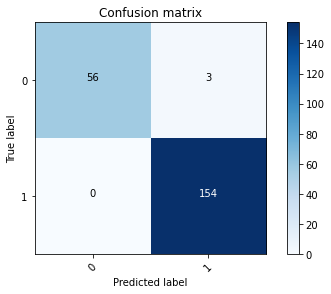

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


plot_confusion_matrix(confusion_matrix(y_test,y_pred), range(2))

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

In [25]:
def plotROC_classifier(clf, X_tmp, y_tmp, X_tmp_test, y_tmp_test): #cv):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    viz = RocCurveDisplay.from_estimator(
            clf,
            X_tmp_test,
            y_tmp_test,
            name="ROC fold {}".format(0),#i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()

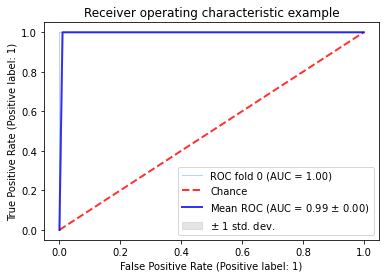

In [26]:
plotROC_classifier(svclassifier, X, y, X_test, y_test)

# Memebership inference

based on code from Simon (https://github.com/jim-smith/GRAIMatter/blob/main/WP1/notebooks/membership_inference_example.ipynb)

### Construct a dataset with label of whether or not in the training

Construct a dataset with label of whether or not in the training.

In [27]:
def classification_labels(clf):
    miX = np.concatenate(
        (
            #rf.predict_proba(train_data.drop(columns=["outcome"])),
            #rf.predict_proba(val_data.drop(columns=["outcome"]))
            clf.predict(X_train),
            clf.predict(X_test)
        )
    )

    miY = np.concatenate(
        (
        np.ones((len(X_train), 1), int),
        np.zeros((len(X_test), 1), int)
        )
    ).flatten()
    miX = miX.reshape(-1, 1)
    return(miX,miY)

miX, miY = classification_labels(svclassifier)

Split the MI dataset into train and test portions

In [28]:
mi_train_x, mi_test_x, mi_train_y, mi_test_y = train_test_split(miX, miY, test_size=0.2, stratify=miY)

In [29]:
mi_train_x = mi_train_x.reshape(-1, 1)
mi_test_x = mi_test_x.reshape(-1, 1)

Train the membership inference classifier

In [30]:
#Random Forest example
mi_rf = RandomForestClassifier()
mi_rf.fit(mi_train_x, mi_train_y)

RandomForestClassifier()

In [31]:
mi_svclassifier = SVC(kernel='rbf', probability=True)
mi_svclassifier.fit(mi_train_x, mi_train_y)

SVC(probability=True)

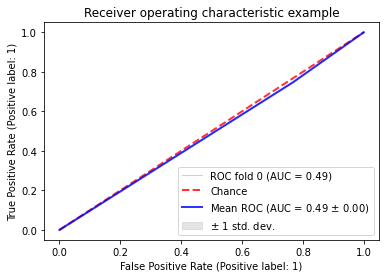

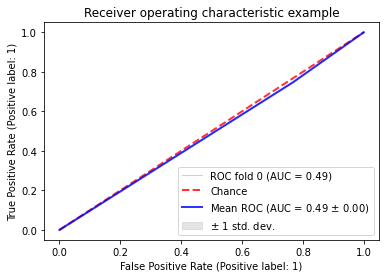

In [32]:
plotROC_classifier(mi_rf, miX, miY, mi_test_x, mi_test_y)
plotROC_classifier(mi_svclassifier, miX, miY, mi_test_x, mi_test_y)

In [33]:
mi_pred_y_rf = mi_rf.predict_proba(mi_test_x)
mi_pred_train_y_rf = mi_rf.predict_proba(mi_train_x)

In [34]:
mi_pred_y_svm = mi_svclassifier.predict_proba(mi_test_x)
mi_pred_train_y_svm = mi_svclassifier.predict_proba(mi_train_x)

RandomForest
SVM


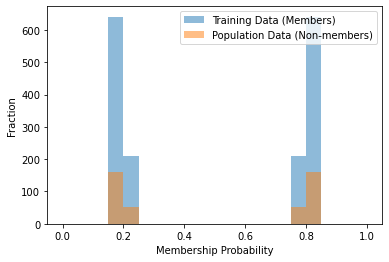

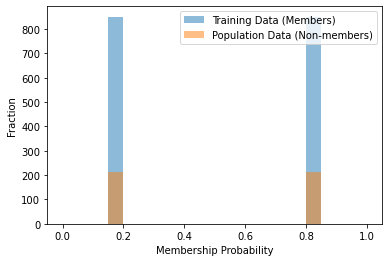

In [35]:
def plot_prob_test_train(pred_test, pred_train):
    fig, ax = plt.subplots()
    plt.hist(np.array(pred_train).flatten(),  alpha=0.5, bins=20, label='Training Data (Members)',
                histtype='bar', range=(0, 1))
    plt.hist(np.array(pred_test).flatten(),  alpha=0.5, bins=20, label='Population Data (Non-members)',
                histtype='bar', range=(0, 1))
    plt.legend()
    plt.xlabel('Membership Probability')
    plt.ylabel('Fraction')

print('RandomForest')
plot_prob_test_train(mi_pred_y_rf, mi_pred_train_y_rf)
print('SVM')
plot_prob_test_train(mi_pred_y_svm, mi_pred_train_y_svm)